<div class="alert alert-info">

<H2> Part 3 ‑ Predictive modeling </H2>

<p>
Ultimate is interested in predicting rider retention. To help explore this question, we have provided a sample dataset of a cohort of users who signed up for an Ultimate account in January 2014. The data was pulled several months later; we consider a user retained if they were “active” (i.e. took a trip) in the preceding 30 days.
</p>

<p>
We would like you to use this data set to help understand what factors are the best predictors for retention, and offer suggestions to operationalize those insights to help Ultimate.
</p>

The data is in the attached file ultimate_data_challenge.json.
    <ol>
        <li> Perform any cleaning, exploratory analysis, and/or visualizations to use the provided data for this analysis (a few sentences/plots describing your approach will suffice). What fraction of the observed users were retained?</li>
        <li> Build a predictive model to help Ultimate determine whether or not a user will be active in their 6th month on the system. Discuss why you chose your approach, what alternatives you considered, and any concerns you have. How valid is your model? Include any key indicators of model performance.</li>
        <li> Briefly discuss how Ultimate might leverage the insights gained from the model to improve its long term rider retention (again, a few sentences will suffice).</li>
                
   </ol>
    
<H3> Assumptions Made </H3>

The date of when the data was pulled is not given, so I cannot tell if they had a trip in the 30 days before that date, nor is a user ID given.

Thus, I will assume:
    <ol>
        <li>That the most recent trip taken was the day the data was pulled</li>
        <li>Each row represents a summary of a unique user </li>
    </ol>

<H3> Data description </H3>

The following fields are communicated as follows:
    <ol>
        <li>city: city this user signed up in</li>
        <li>phone: primary device for this user </li>
        <li>signup_date: date of account registration; in the form ‘YYYY MM DD’ </li>
        <li>last_trip_date: the last time this user completed a trip; in the form ‘YYYY MM DD’ </li>
        <li>avg_dist: the average distance in miles per trip taken in the first 30 days after signup </li>
        <li>avg_rating_by_driver: the rider’s average rating over all of their trips </li>
        <li>avg_rating_of_driver: the rider’s average rating of their drivers over all of their trips </li>
        <li>surge_pct: the percent of trips taken with surge multiplier > 1 </li>
        <li>avg_surge: The average surge multiplier over all of this user’s trips </li>
        <li>trips_in_first_30_days: the number of trips this user took in the first 30 days after
signing up </li>
        <li>ultimate_black_user: TRUE if the user took an Ultimate Black in their first 30 days;
FALSE otherwise </li>
        <li>weekday_pct: the percent of the user’s trips occurring during a weekday </li>
    </ol>

<div class="alert alert-success">
<H3> 1. Perform any cleaning, exploratory analysis, and/or visualizations to use the provided data for this analysis (a few sentences/plots describing your approach will suffice). What fraction of the observed users were retained? </H3>
</div>

In [2]:
# imports
import pandas as pd
import numpy as np
import json
import pickle


# data viz imports
import matplotlib.pyplot as plt
plt.style.use('tableau-colorblind10')
import seaborn as sns


# time-series imports
from datetime import datetime


# imports for xgboost
from sklearn.metrics import accuracy_score, mean_squared_error
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier, cv, plot_importance

from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

In [3]:
# load data
with open('data/ultimate_data_challenge.json') as f:
    data = json.load(f)

# put data info pandas dataframe
user_data = pd.DataFrame(data)

# convert dates to datetime objects
user_data['signup_date'] = pd.to_datetime(user_data['signup_date'])
user_data['last_trip_date'] = pd.to_datetime(user_data['last_trip_date'])

# find the date the data was pulled
pull_date = user_data.last_trip_date.max()

# determine 30 days previous to the pull day
cut_off_day = pull_date - pd.Timedelta('30 days')

# add active status to dataframe 0= inactive, 1 = active
user_data['active_status'] = (user_data.last_trip_date > cut_off_day).astype('int')

# add dummies to categorical data
user_data = pd.get_dummies(user_data, columns = ['city', 'phone'])

In [4]:
# separate the active and inactive users
active_user = user_data[user_data.active_status == 1]
inactive_user = user_data[user_data.active_status == 0]

In [5]:
# fraction of the observed users that were retained
fraction = round((len(active_user.active_status)/len(user_data.active_status)) * 100, 2)
print('{} percent of users were retained.'.format(fraction))

36.62 percent of users were retained.


In [6]:
# calculate the mean and standard deviation for each feature
feature_columns = ['avg_dist', 'avg_rating_by_driver', 'avg_rating_of_driver', 'avg_surge',
 'surge_pct', 'ultimate_black_user', 'weekday_pct', 'city_Astapor',
 "city_King's Landing", 'city_Winterfell', 'phone_Android','phone_iPhone']
stats_dict = {}
for col in feature_columns:
    stats_dict[col] = [active_user[col].mean(), active_user[col].std(),
                       inactive_user[col].mean(),inactive_user[col].std()]

In [7]:
# create a dataframe of the statistics
stats_df = pd.DataFrame.from_dict(stats_dict, orient='index').rename(columns = {0:'active_mean', 1:'active_std', 2:'inactive_mean', 3:'inactive_std'})

Text(0.5, 1.0, 'Average of Features for Active and Inactive Users')

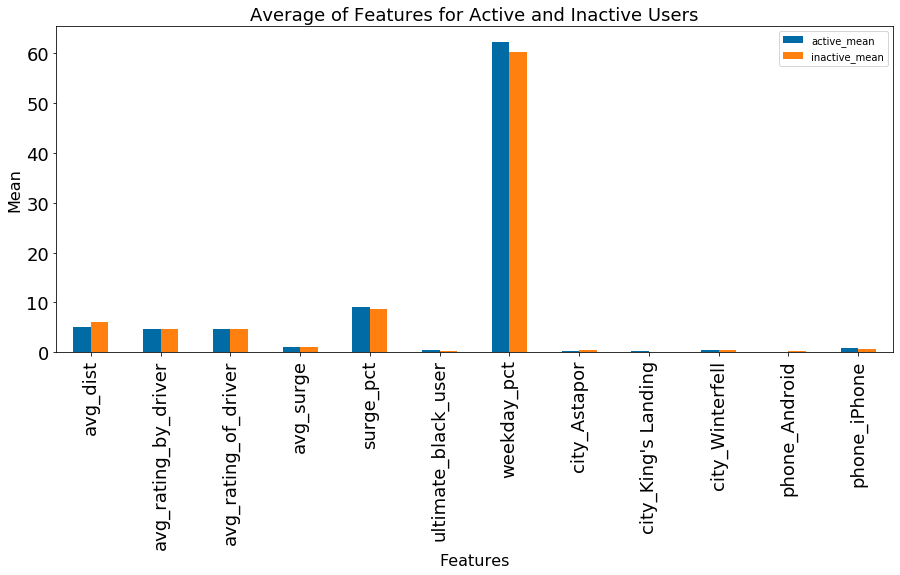

In [16]:
# visualize the statistics
stats_df[['active_mean', 'inactive_mean']].plot(kind = 'bar', yerr=stats_df[['active_std','inactive_std']], figsize = (15,6), fontsize = 18)
plt.xlabel('Features',fontsize = 16)
plt.ylabel('Mean', fontsize = 16)
plt.title('Average of Features for Active and Inactive Users', fontsize = 18)

<div class="alert alert-warning">
<strong>The bar graph of the statistcs shows there is not a substantial difference between the average of the features for active and inactive users.  It also shows the weekday_pct feature has a much larger scale than the others, so the data may need to be normalized</strong>
</div>

<div class="alert alert-success">
<H3> 1. Build a predictive model to help Ultimate determine whether or not a user will be active in their 6th month on the system. Discuss why you chose your approach, what alternatives you considered, and any concerns you have. How valid is your model? Include any key indicators of model performance. </H3>
</div>

__Analysis Approach:__

This problem is a binary classification with both numerical and categorical data with 50,000 data points.

XGBoost open-source algorithm that has recently been dominating applied machine learning. It's library provides a gradient boosting framework for C++, Java, Python, R, and Julia and is appropriate for this data set for speed and memory efficiency.
    
Statistical modeling methods that can apply to this data set are random forests and logistic regression. One of the drawbacks of using a tree-based model is this is a binary classification problem with both numerical and categorical data with 50,000 data points.

_Optimization of XGBoost Classifer Model_

> 1. split data into training and test sets
> 2. optimize hyperparameters using the training set and random cross-validation to estimate the skill of machine learning models
> 3. validate using an unoptimized model AND the test set
> 4. train optimized model using the entire feature set

<div class="alert alert-success">
<H3>1. Split Data</H3>
</div>

In [20]:
# define features and target
X = user_data[feature_columns]
y = user_data.active_status

# split training and test data
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3, random_state=123)

<div class="alert alert-success">
<H3>2. Hyperparameter optimization</H3>
</div>

In [21]:
# dictionary of parameters to optimize, and the range of optimization values
parameters = {
    'max_delta_step':[0,0.05],
    'scale_pos_weight':[0.95, 0.9],
    'subsample':[1,0.8],
    'learning_rate': [0.25, 0.2, 0.1],
    'min_child_weight':[0,1,2],
    'gamma':[1, 2, 3]
    }

In [22]:
# instantiate classifier
xg_clf = XGBClassifier(objective = 'binary:logistic', random_state = 42, silent = 1, n_estimators=10, max_depth= 8)

# RandomSearch
grid_search = GridSearchCV(param_grid= parameters, estimator = xg_clf, cv=3, scoring='accuracy')
grid_search.fit(X_train,y_train)

GridSearchCV(cv=3, error_score='raise-deprecating',
             estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                     colsample_bylevel=1, colsample_bynode=1,
                                     colsample_bytree=1, gamma=0,
                                     learning_rate=0.1, max_delta_step=0,
                                     max_depth=8, min_child_weight=1,
                                     missing=None, n_estimators=10, n_jobs=1,
                                     nthread=None, objective='binary:logistic',
                                     random_state=42, reg_alpha=0, reg_lambda=1,
                                     scale_pos_weight=1, seed=None, silent=1,
                                     subsample=1, verbosity=1),
             iid='warn', n_jobs=None,
             param_grid={'gamma': [1, 2, 3], 'learning_rate': [0.25, 0.2, 0.1],
                         'max_delta_step': [0, 0.05],
                         'min_child_

In [23]:
# Print best parameters and results
print(grid_search.best_params_)
print(grid_search.best_score_)

{'gamma': 3, 'learning_rate': 0.25, 'max_delta_step': 0, 'min_child_weight': 1, 'scale_pos_weight': 0.95, 'subsample': 0.8}
0.7833142857142857


<div class="alert alert-success">
<H3>3. Validate optimized parameters</H3>
</div>

In [24]:
# optimized parameters
optimized_parameters = {'objective':'binary:logistic',
                        'n_estimators': 10,
                        'random_state': 42,
                        'silent': 0,
                        'subsample': 1, 
                        'scale_pos_weight': 0.95, 
                        'min_child_weight': 1, 
                        'max_depth': 8, 
                        'max_delta_step': 0, 
                        'learning_rate': 0.2, 
                        'gamma': 3
                       }

In [25]:
# instantiate classifier
xg_clf_opt = XGBClassifier(**optimized_parameters)
xg_clf_opt.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=3,
              learning_rate=0.2, max_delta_step=0, max_depth=8,
              min_child_weight=1, missing=None, n_estimators=10, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=42,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=0.95, seed=None,
              silent=0, subsample=1, verbosity=1)

In [26]:
# predict the labels
y_opt_pred = xg_clf_opt.predict(X_train)

# score model
score = accuracy_score(y_train, y_opt_pred)

# print accuracy
print("The resulting accuracy of the optimized classifier is {}.".format(round(score,4)))

The resulting accuracy of the optimized classifier is 0.8033.


In [27]:
# train unoptimized model
xg_clf.fit(X_train, y_train)

# predict the labels of unoptimized model
y_unopt_pred = xg_clf.predict(X_train)

# score model
un_score = accuracy_score(y_train, y_unopt_pred)

# print accuracy
print("The resulting accuracy of the unoptimized classifier is {}.".format(round(un_score,4)))

The resulting accuracy of the unoptimized classifier is 0.7969.


<div class="alert alert-warning">
<strong>The optimization process did improve the model using the training data, so the next step is to see how it performs with the test set.</strong>
</div>

In [28]:
# predict the labels
y_opt_test = xg_clf_opt.predict(X_test)

# score model
test_score = accuracy_score(y_test, y_opt_test)

# print accuracy
print("The resulting accuracy of the optimized classifier for the test set is {}.".format(round(test_score,4)))

The resulting accuracy of the optimized classifier for the test set is 0.7873.


In [29]:
# predict the labels of unoptimized model using the test set
y_unopt_test = xg_clf.predict(X_train)

# score model
test_score = accuracy_score(y_train, y_unopt_test)

# print accuracy
print("The resulting accuracy of the unoptimized classifier is {}.".format(round(test_score,4)))

The resulting accuracy of the unoptimized classifier is 0.7969.


<div class="alert alert-warning">
<strong>The optimized model performs worse with the test set, which means it is overfitting. Therefore, I will train the final model with all of the data using the default values</strong>
</div>

In [30]:
# instantiate classifier
xg_clf_final = XGBClassifier(objective = 'binary:logistic', random_state = 42, silent = 1, n_estimators=200, max_depth= 8)

# train final model
xg_clf_final.fit(X, y)

# save model
pickle.dump(xg_clf_final, open('final_model.pickle', 'wb'))

<div class="alert alert-success">
<H2> Model Insights </H2>

<H3>
<p>
    
<li>Determine the most important features of the model</li>
<li>Discuss what that means for rider retention</li>

</p>
</H3>
</div>

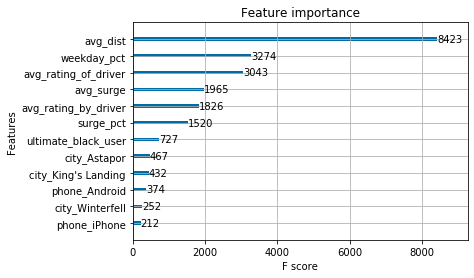

In [31]:
plot_importance(xg_clf_final)

<div class="alert alert-warning">
<H1> Conclusions </H1>
<H2>
<strong>The default parameters produced the best performing XGBoost model, resulting in a classification accuracy of 80.33% for the test data.  The factors that most heavily influence rider retention are the average distance in miles per trip taken in the first 30 days after signup and the percent of the user's trips occuring during a weekday. </strong>
</H2>
</div>